# Imports

In [1]:
# First, install correct versions (run this once)
!pip install --upgrade scikit-learn==1.3.0 imbalanced-learn
# then restart

INFO: pip is looking at multiple versions of imbalanced-learn to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Load data


In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [4]:
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
test.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [6]:
train.shape

(18524, 9)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         6175 non-null   int64  
 1   Time_spent_Alone           5750 non-null   float64
 2   Stage_fear                 5577 non-null   object 
 3   Social_event_attendance    5778 non-null   float64
 4   Going_outside              5709 non-null   float64
 5   Drained_after_socializing  5743 non-null   object 
 6   Friends_circle_size        5825 non-null   float64
 7   Post_frequency             5767 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 386.1+ KB


# Exploratory Data Analysis (EDA)


Text(0, 0.5, 'Count')

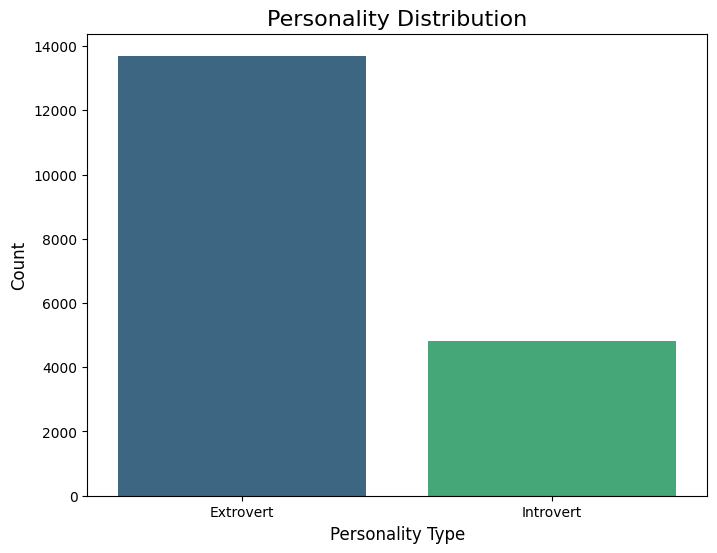

In [9]:
# Target distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Personality', data=train, palette='viridis')
plt.title('Personality Distribution', fontsize=16)
plt.xlabel('Personality Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

In [10]:
# Add percentages
total = len(train)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 50
    ax.annotate(percentage, (x, y), ha='center', fontsize=12)
    plt.show()

In [11]:
# Numerical features
num_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                'Friends_circle_size', 'Post_frequency']

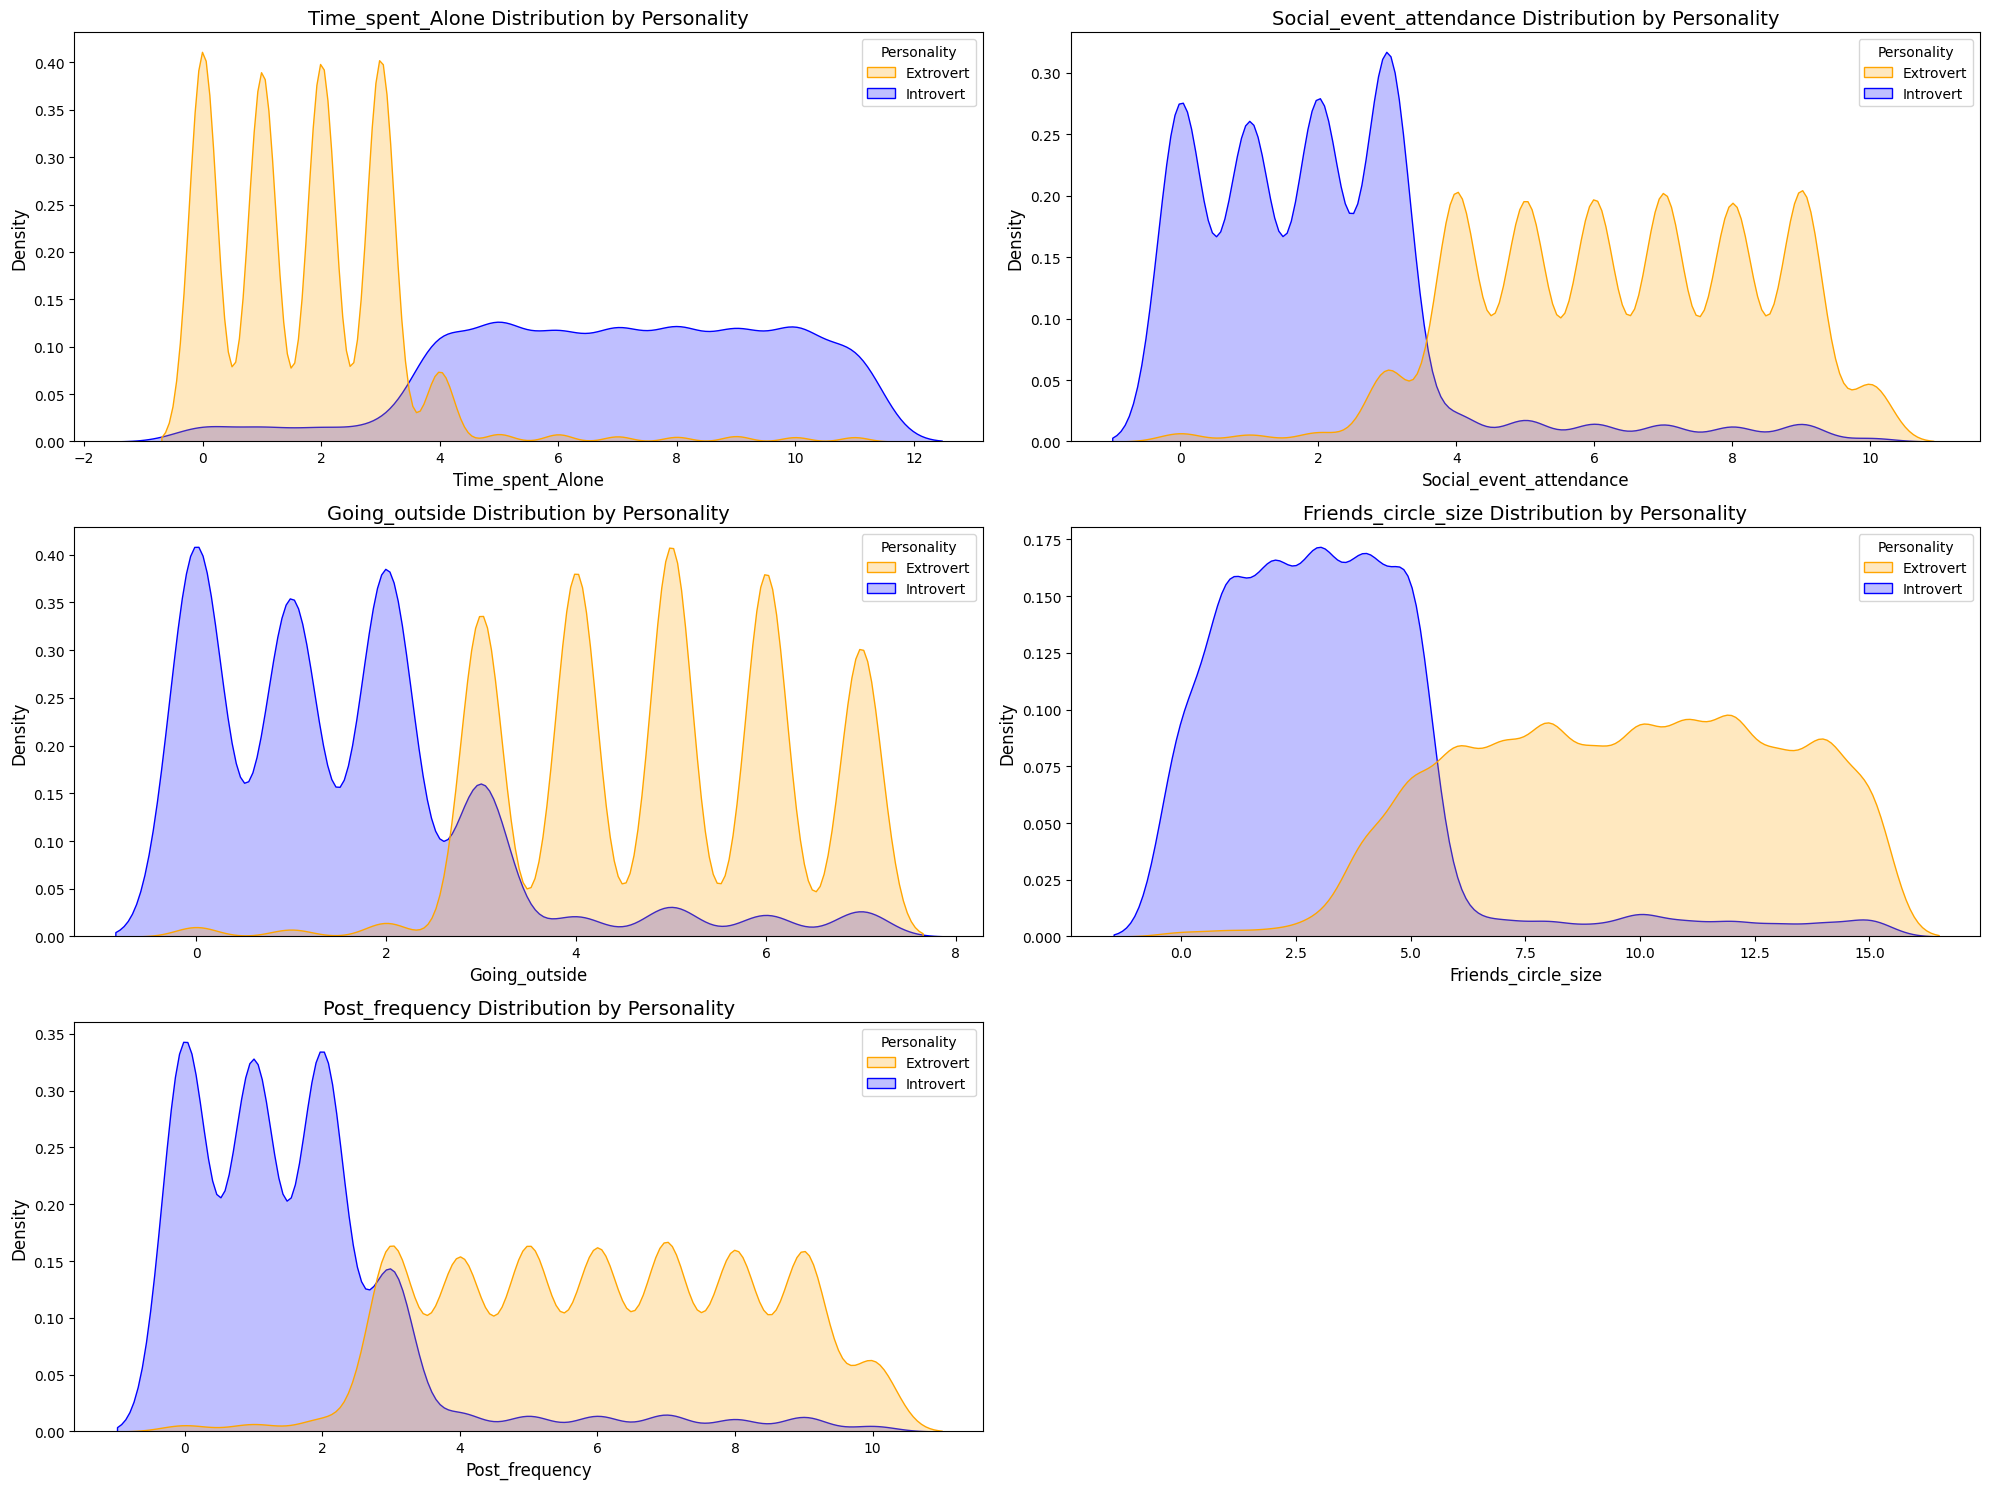

In [12]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=train, x=feature, hue='Personality', fill=True, common_norm=False, 
                palette={'Introvert': 'blue', 'Extrovert': 'orange'})
    plt.title(f'{feature} Distribution by Personality', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()


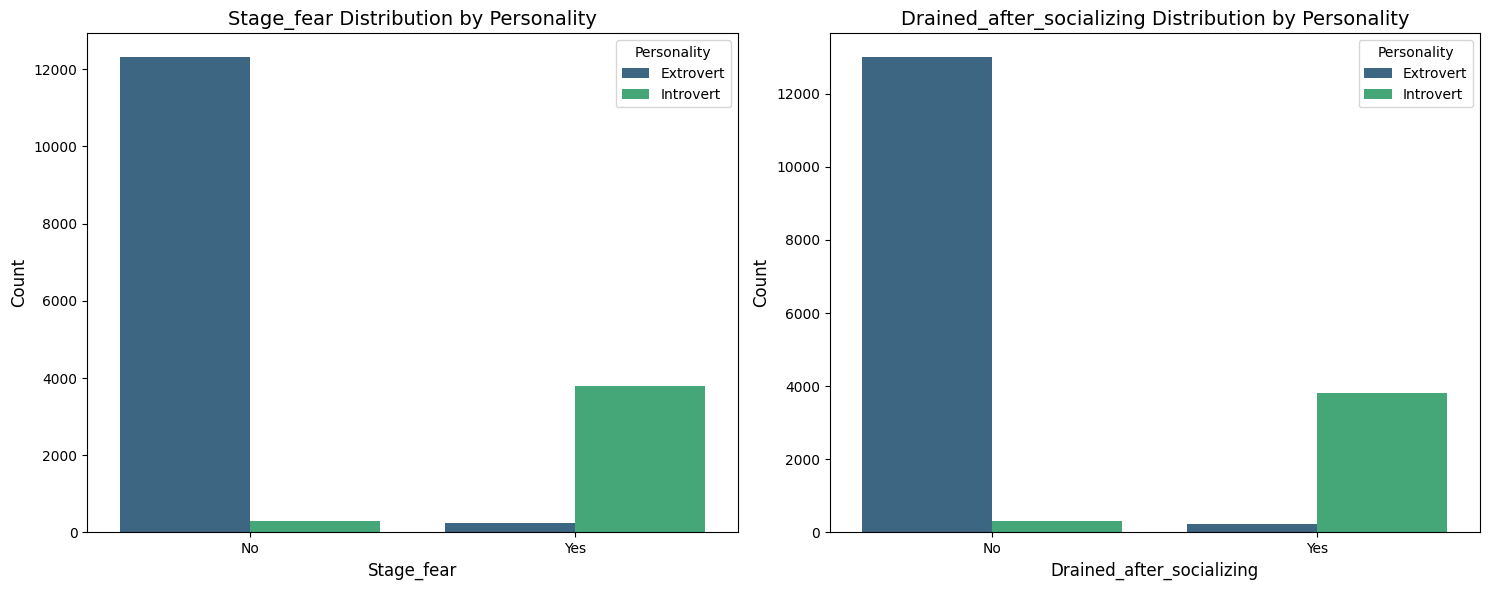

In [13]:
# Categorical features
cat_features = ['Stage_fear', 'Drained_after_socializing']

plt.figure(figsize=(15, 6))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(1, 2, i)
    sns.countplot(data=train, x=feature, hue='Personality', palette='viridis')
    plt.title(f'{feature} Distribution by Personality', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Personality')
plt.tight_layout()
plt.show()

# Correlation Analysis

In [14]:
# Encode target for correlation
train_corr = train.copy()

In [15]:
# Convert categorical columns to numerical values
train_corr['Stage_fear'] = train_corr['Stage_fear'].map({'Yes': 1, 'No': 0})
train_corr['Drained_after_socializing'] = train_corr['Drained_after_socializing'].map({'Yes': 1, 'No': 0})
train_corr['Personality'] = train_corr['Personality'].map({'Introvert': 0, 'Extrovert': 1})

In [16]:
# Drop ID column as it's not useful for correlation
train_corr = train_corr.drop('id', axis=1)

In [17]:
corr = train_corr.corr()

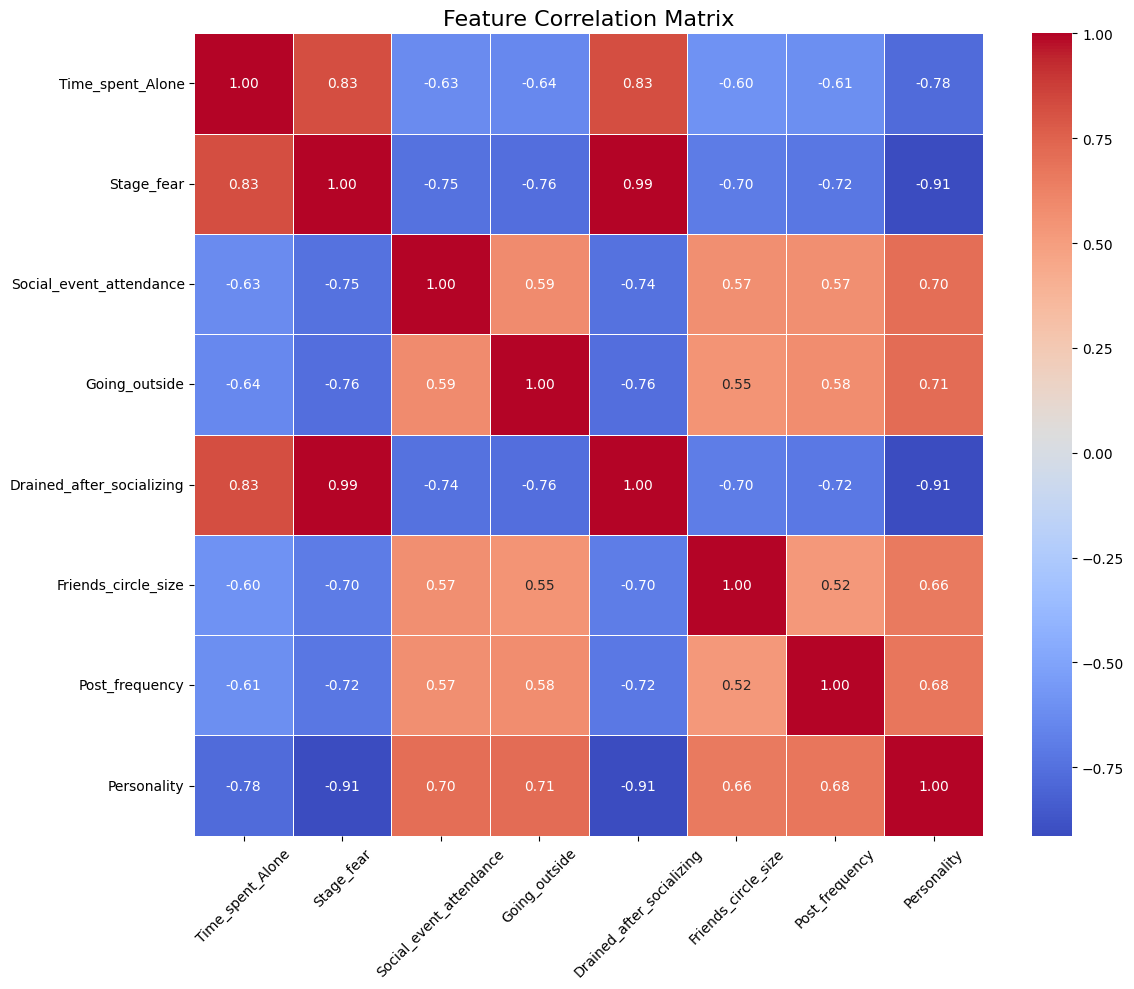

In [18]:
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
            annot_kws={'size': 10}, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

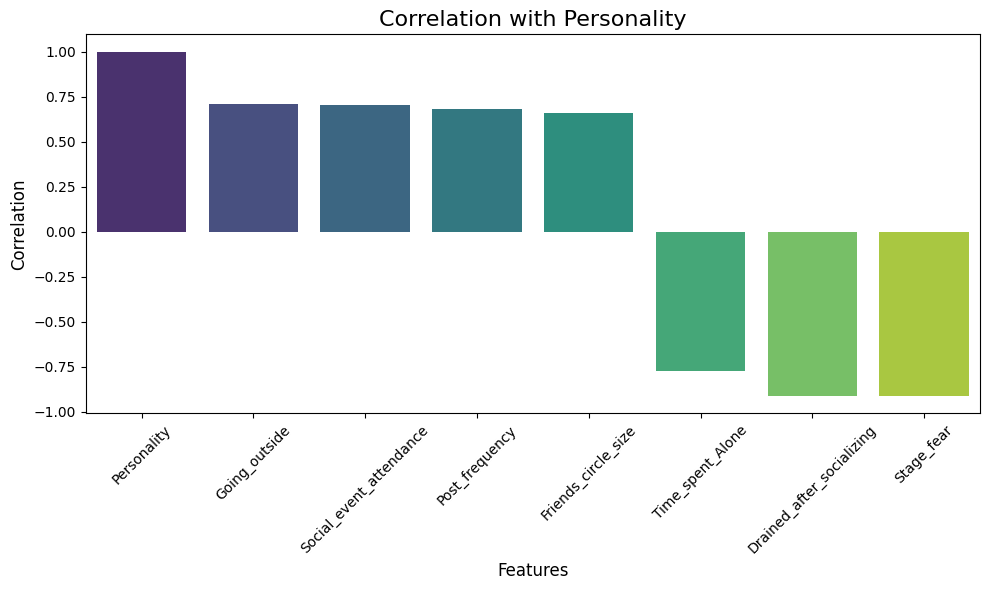

In [19]:
# Correlation with target
target_corr = corr['Personality'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values, palette='viridis')
plt.title('Correlation with Personality', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Engineering

In [20]:
# Create new features
def create_features(df):
    df = df.copy()
    # Social interaction ratio
    df['Social_Interaction_Ratio'] = df['Social_event_attendance'] / (df['Time_spent_Alone'] + 1e-5)
    
    # Energy balance feature
    df['Energy_Balance'] = df['Drained_after_socializing'].map({'Yes': -1, 'No': 1}) * df['Social_event_attendance']
    
    # Social activity index
    df['Social_Activity_Index'] = (df['Social_event_attendance'] + df['Going_outside'] + 
                                   df['Friends_circle_size'] / 10)
    
    # Post frequency adjusted for social circle
    df['Post_Frequency_Adjusted'] = df['Post_frequency'] / (df['Friends_circle_size'] + 1)
    
    return df

In [21]:
# Apply feature engineering
train_fe = create_features(train)
test_fe = create_features(test)

In [22]:
# Show new features
print("Engineered features preview:")
print(train_fe[['Social_Interaction_Ratio', 'Energy_Balance', 
                'Social_Activity_Index', 'Post_Frequency_Adjusted']].head())

Engineered features preview:
   Social_Interaction_Ratio  Energy_Balance  Social_Activity_Index  \
0             600000.000000             6.0                   11.5   
1                  6.999930             7.0                   11.0   
2                  0.166666             NaN                    1.3   
3                  2.333326             7.0                   11.1   
4                  3.999960             4.0                    9.3   

   Post_Frequency_Adjusted  
0                 0.312500  
1                 0.727273  
2                 0.000000  
3                 0.416667  
4                      NaN  


# Data Preprocessing

In [23]:
# Handle missing values
def handle_missing(df):
    df = df.copy()
    # Numerical columns: fill with median
    num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                'Friends_circle_size', 'Post_frequency', 'Social_Interaction_Ratio',
                'Social_Activity_Index', 'Post_Frequency_Adjusted']
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Categorical columns: fill with mode
    cat_cols = ['Stage_fear', 'Drained_after_socializing']
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    # Energy_Balance might have NaNs from categorical mapping
    df['Energy_Balance'].fillna(df['Energy_Balance'].median(), inplace=True)
    
    return df

In [24]:
# Apply missing value handling
train_clean = handle_missing(train_fe)
test_clean = handle_missing(test_fe)

In [25]:
# Verify no missing values
print("\nMissing values in training data after handling:")
print(train_clean.isnull().sum().sum())
print("Missing values in test data after handling:")
print(test_clean.isnull().sum().sum())


Missing values in training data after handling:
0
Missing values in test data after handling:
0


# Addressing Class Imbalance with Undersampling

In [26]:
# Separate features and target
X = train_clean.drop(['id', 'Personality'], axis=1)
y = train_clean['Personality']

In [27]:
# Apply undersampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

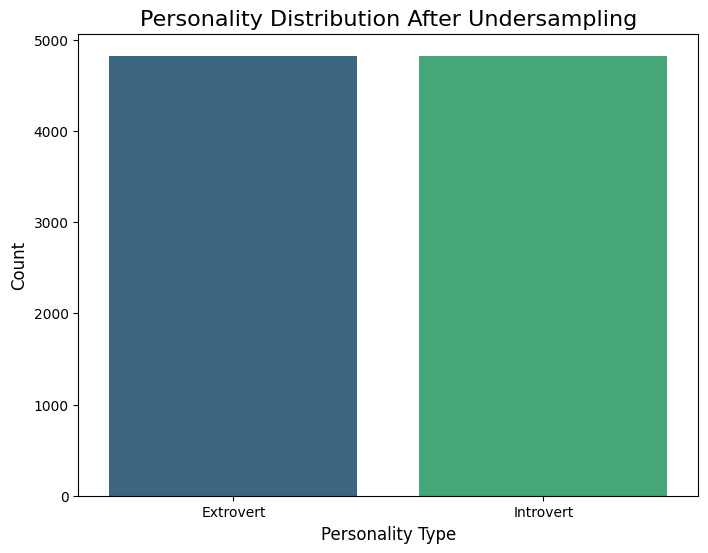

In [28]:
# Check new distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_res, palette='viridis')
plt.title('Personality Distribution After Undersampling', fontsize=16)
plt.xlabel('Personality Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# SVC Model with Error Prevention

In [29]:
# Define preprocessing
categorical_features = ['Stage_fear', 'Drained_after_socializing']
numerical_features = [col for col in X_res.columns if col not in categorical_features]

In [30]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)

In [31]:
# Create full pipeline with feature selection
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_classif, k=10)),
    ('classifier', SVC(probability=True, random_state=42))
])

In [32]:
# Parameter grid for tuning
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'feature_selector__k': [8, 10, 12]
}

In [33]:
# Setup GridSearchCV with stratified k-fold
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

In [34]:
# Train model
grid_search.fit(X_res, y_res)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Time_spent_Alone',
                                                                          'Social_event_attendance',
                                                                          'Going_outside',
                                                                          'Friends_circle_size',
                                                                          'Post_frequency',
                                                                          'Social_Interaction_Ratio',
                                                                          'Energy_Balance',
                                                                          'Social_Activity_Index',
                                                                          'Post_Frequency_Adjusted']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Stage_fear',
                                                                          'Drained_after_socializing'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__kernel': ['linear', 'rbf'],
                         'feature_selector__k': [8, 10, 12]},
             scoring='accuracy', verbose=1)

In [35]:
# Best parameters
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Best parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf', 'feature_selector__k': 12}
Best cross-validation accuracy: 0.9590


In [36]:
# Get best model
best_model = grid_search.best_estimator_

# Model Evaluation

In [37]:
# Cross-validated metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_res, y_res, cv=cv, scoring='accuracy')
print(f"\nCross-validated Accuracy: {np.mean(scores):.4f} (± {np.std(scores):.4f})")


Cross-validated Accuracy: 0.9590 (± 0.0050)


In [38]:
# Train-test split evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [39]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

In [40]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.93      0.98      0.96       965
   Introvert       0.98      0.93      0.96       965

    accuracy                           0.96      1930
   macro avg       0.96      0.96      0.96      1930
weighted avg       0.96      0.96      0.96      1930



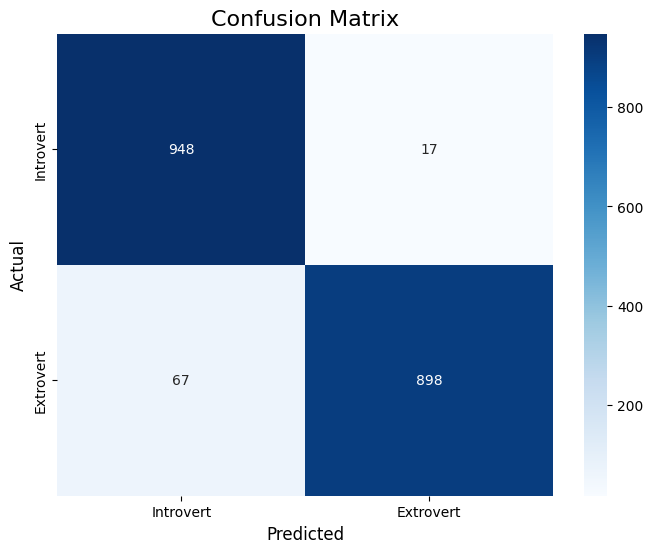

In [41]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Introvert', 'Extrovert'], 
            yticklabels=['Introvert', 'Extrovert'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

In [42]:
# Get selected features
feature_selector = best_model.named_steps['feature_selector']
preprocessor = best_model.named_steps['preprocessor']

In [43]:
# Get feature names after preprocessing
cat_features_transformed = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numerical_features, cat_features_transformed])

In [44]:

# Get selected feature mask
selected_mask = feature_selector.get_support()
selected_features = all_features[selected_mask]


In [45]:

# Get SVM coefficients for linear kernel
if best_model.named_steps['classifier'].kernel == 'linear':
    coefficients = best_model.named_steps['classifier'].coef_[0]
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': coefficients
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title('Feature Importance (SVM Coefficients)', fontsize=16)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

# Generate Predictions

In [46]:
# Prepare test data
test_final = test_clean.drop('id', axis=1)

# Make predictions
test_preds = best_model.predict(test_final)


In [47]:

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'Personality': test_preds
})

# Save submission
submission.to_csv('submission444.csv', index=False)
print("\nSubmission file created successfully!")
print(submission.head())



Submission file created successfully!
      id Personality
0  18524   Extrovert
1  18525   Introvert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Introvert


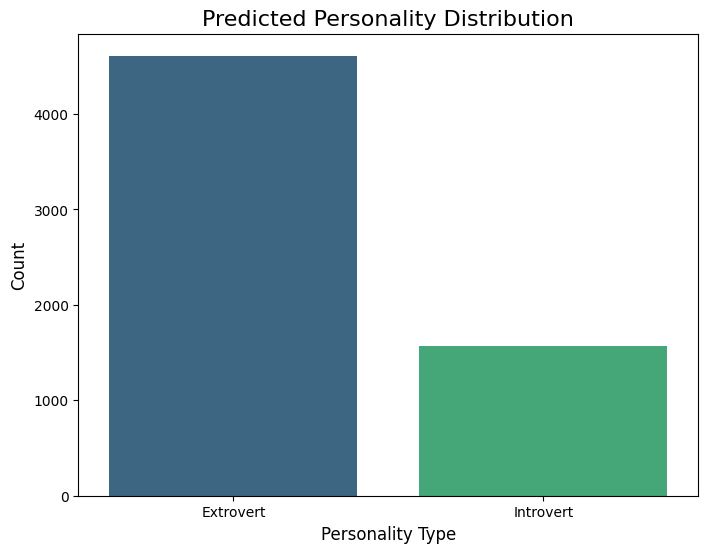

In [48]:

# Class distribution in predictions
plt.figure(figsize=(8, 6))
sns.countplot(x='Personality', data=submission, palette='viridis')
plt.title('Predicted Personality Distribution', fontsize=16)
plt.xlabel('Personality Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()